## Loading Images

SAM's predictor.set_image function expects the following format for the image:

Arguments:
      image (np.ndarray): The image for calculating masks. Expects an
        image in HWC uint8 format, with pixel values in [0, 255].
      image_format (str): The color format of the image, in ['RGB', 'BGR'].

In [1]:
# load png image into numpy array
import numpy as np
from PIL import Image

path = "/Users/janulm/Documents/ETH/SM10/Computational Intelligence Lab/eth-cil-road-segmentation/data/training/images/satimage_0.png"

im_frame = Image.open(path)
im_frame = im_frame.convert('RGB')
np_frame = np.array(im_frame)


In [2]:
print(np_frame.shape, np_frame.dtype, np_frame.min(), np_frame.max())

(400, 400, 3) uint8 15 252


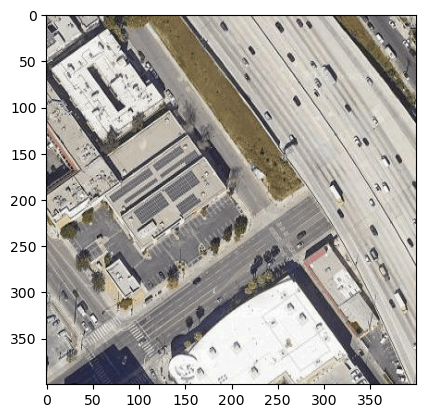

In [3]:
# show the image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(np_frame)
plt.show()

## SAM All mask version

In [4]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

model_path = "/Users/janulm/Documents/ETH/SM10/Computational Intelligence Lab/eth-cil-road-segmentation/models/sam_vit_h_4b8939.pth"
sam = sam_model_registry["default"](checkpoint=model_path)



# all masks
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(np_frame)

/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


print(masks)

126


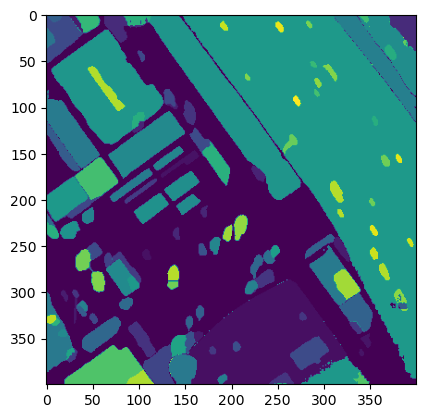

In [5]:

print(len(masks))

def masks_to_image(masks):
    # add all the masks with a different color together and show them as one image
    mask = np.zeros_like(masks[0]["segmentation"]).astype(np.uint8)
    i = len(masks) + 10
    for m in masks:
        # convert the binary {true,false} mask to {0,1} mask 
        mask += i * m["segmentation"].astype(np.uint8)
        i-=1
    return mask



mask = masks_to_image(masks)
plt.imshow(mask)



## Empty Mask

We also compute the empty mask, since we assume that the SAM more or less often clusters everything the street.

126


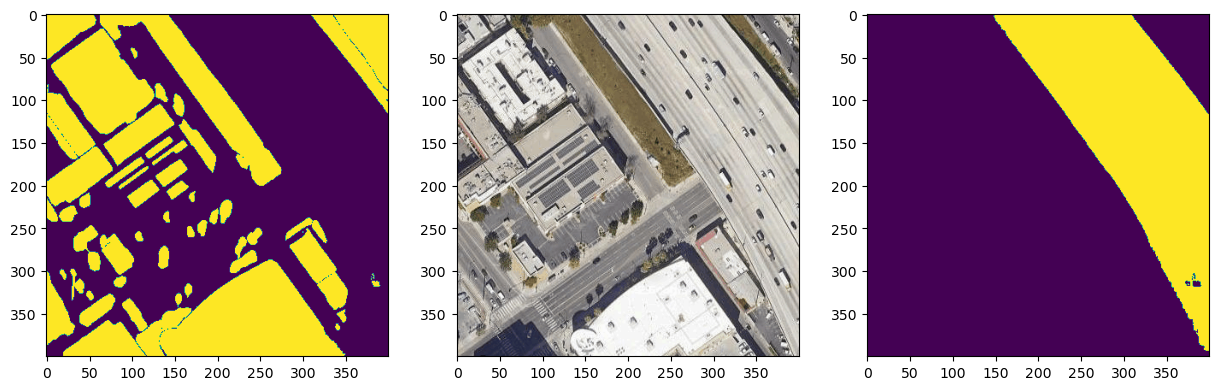

In [6]:

# show the mask using matplotlib
#plt.imshow(masks)
#plt.show()
print(len(masks))

def masks_to_empty_mask(masks):
    # add all the masks with a different color together and show them as one image
    mask = np.zeros_like(masks[0]["segmentation"]).astype(np.uint8)
    for m in masks:
        # convert the binary {true,false} mask to {0,1} mask
        mask = np.maximum(m["segmentation"].astype(np.uint8), mask)
    

    return mask



mask = masks_to_empty_mask(masks)

# make plot of this mask, and the gt image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mask-masks[0]["segmentation"])
ax[1].imshow(np_frame)
ax[2].imshow(masks[0]["segmentation"])


This could work well but leaves open the problem of finding out what mask corresponds to a street, which could be solved by using other pretrained models

## SAM Queried Mask

We now explore the idea of having a mask, that has only very little points but that are certainly a street. These could be used as a query for SAM. We will test if good street queries will deliver a good mask of streets. 

In [10]:
predictor = SamPredictor(sam)
predictor.set_image(np_frame)


"""
    point_coords (np.ndarray or None): A Nx2 array of point prompts to the
            model. Each point is in (X,Y) in pixels.

    point_labels (np.ndarray or None): A length N array of labels for the
            point prompts. 1 indicates a foreground point and 0 indicates a
            background point.
"""

points = np.array([[350,250], [150, 100],[100,350],[30,300],[250,100]])
point_labels = np.array([1, 1,1,1,1])

masks, quality, logits = predictor.predict(points, point_labels,multimask_output=False)

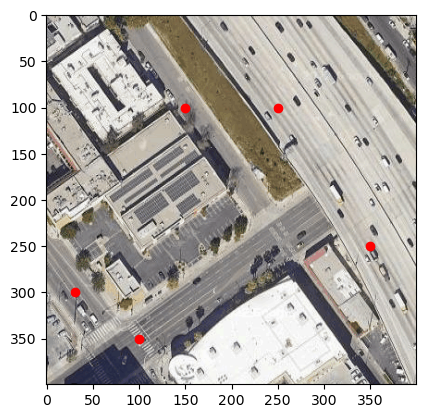

In [11]:
# show the original image and mark the query points in red
plt.imshow(np_frame)
plt.scatter(points[:, 0], points[:, 1], c='red')
plt.show()


1
[0.7877028]


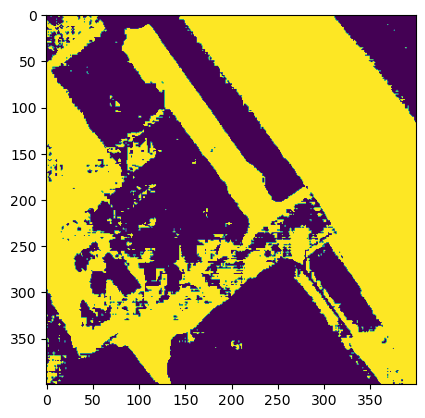

In [12]:
num_masks = masks.shape[0]
print(num_masks)
# plot all masks in the same image
mask = np.zeros_like(masks[0]).astype(np.uint8)
for i in range(num_masks):
    mask += (i+1) * masks[i].astype(np.uint8)

plt.imshow(mask)

print(quality)